# Nearest neighbour search

## Setting up

In [77]:
import numpy as np
from scipy.spatial import distance
import faiss
import time
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
np.random.seed(42)

In [9]:
vector_dimension = 64
num_vectors = 1000000

all_vectors = np.random.random((num_vectors, vector_dimension)).astype('float32')

In [10]:
query_vector = all_vectors[2:3]
num_neighbours = 4

## Exact search

In [11]:
def get_exact_nearest_neighbours(
    query_vector,
    num_neighbours,    
    all_vectors=all_vectors,
    distance_fn=distance.euclidean,
):
    distances = [distance_fn(query_vector, vector) for vector in all_vectors]
        
    sorted_indices = np.argsort(distances)
    
    nearest_indices = sorted_indices[:num_neighbours]
    nearest_distances = np.array(distances)[sorted_indices]
    
    return nearest_distances, nearest_indices

In [12]:
%%time
d, i = get_exact_nearest_neighbours(
    query_vector,
    num_neighbours
)

CPU times: user 16.7 s, sys: 88 ms, total: 16.7 s
Wall time: 16.8 s


In [16]:
d.mean()

3.2575705942099096

In [23]:
i

array([[     2, 162565, 516514, 179362]])

## Faiss searches

### Brute force L2

https://github.com/facebookresearch/faiss/wiki/Getting-started

In [14]:
bf_index = faiss.IndexFlatL2(vector_dimension)
bf_index.add(all_vectors)
print(f'{bf_index.ntotal} vectors added')

1000000 vectors added


In [20]:
%%time
d, i = bf_index.search(query_vector, num_neighbours)

CPU times: user 104 ms, sys: 4 ms, total: 108 ms
Wall time: 103 ms


In [21]:
d.mean()

3.5163112

In [22]:
i

array([[     2, 162565, 516514, 179362]])

### Inverted file with exact post-verification

https://github.com/facebookresearch/faiss/wiki/Faster-search

In [31]:
quantiser = faiss.IndexFlatL2(vector_dimension)
n_cells = 100
if_index = faiss.IndexIVFFlat(quantiser, vector_dimension, n_cells)

if_index.train(all_vectors)
assert if_index.is_trained

if_index.add(all_vectors)
print(f'{if_index.ntotal} vectors added')

1000000 vectors added


In [32]:
%%time
d, i = if_index.search(query_vector, num_neighbours)

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 2.18 ms


In [33]:
d.mean()

3.970962

In [34]:
i

array([[     2, 298105, 806494, 216015]])

### IVFADC (coarse quantizer+PQ on residuals)

https://github.com/facebookresearch/faiss/wiki/Lower-memory-footprint

In [36]:
quantiser = faiss.IndexFlatL2(vector_dimension)
n_cells = 100
n_subquantisers = 8
cq_index = faiss.IndexIVFPQ(quantiser, vector_dimension, n_cells, n_subquantisers, 8)

cq_index.train(all_vectors)
assert cq_index.is_trained

cq_index.add(all_vectors)
print(f'{cq_index.ntotal} vectors added')

1000000 vectors added


In [37]:
%%time
d, i = cq_index.search(query_vector, num_neighbours)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.57 ms


In [38]:
d.mean()

3.897607

In [39]:
i

array([[     2, 298105, 770680, 811898]])

## Compairing searches

In [68]:
def time_function_s(function, *args):
    start_time = time.time()
    output = function(*args)
    time_taken = (time.time() - start_time)
    
    return time_taken, output

In [69]:
times = []
mean_distances = []

for function in [
    get_exact_nearest_neighbours,
    bf_index.search,
    if_index.search,
    cq_index.search,
]:
    t, (d, i) = time_function_s(
        function,
        query_vector,
        num_neighbours
    )
    
    times.append(t)
    mean_distances.append(d.mean())

print(times)
print(mean_distances)

[18.233532428741455, 0.04473519325256348, 0.0010671615600585938, 0.0001895427703857422]
[3.2575705942099096, 3.5163112, 3.970962, 3.897607]


In [72]:
time_df = pd.DataFrame({
    'search': ['exact', 'brute force', 'inverted file', 'course quantiser'],
    'time_s': times,
    'mean_distance': mean_distances
})

time_df['log_time_s'] = np.log10(time_df['time_s'])

time_df

,search,time_s,mean_distance,log_time_s
0,exact,18.233532,3.257571,1.260871
1,brute force,0.044735,3.516311,-1.349351
2,inverted file,0.001067,3.970962,-2.971770
3,course quantiser,0.000190,3.897607,-3.722293


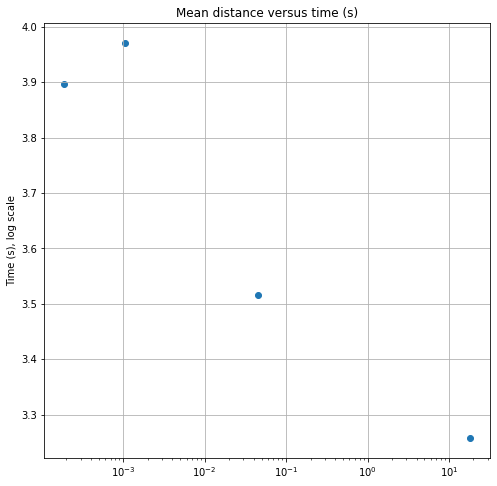

In [86]:
plt.figure(figsize=(8, 8))
plt.scatter(
    x=time_df['time_s'],
    y=time_df['mean_distance'],
)
plt.xscale('log')
plt.grid()
plt.title('Mean distance versus time (s)')
plt.ylabel('Mean distance')
plt.ylabel('Time (s), log scale')
plt.show()